Phase transition diagrams of the Basis Pursuit algorithm for various random matrices with different "concentration properties"
===================================

$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\E}{\mathbb{E}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$


The aim of this norebooks is to introduce students to a pretty useful tool called the "phase transition diagram" (PTD). PTD are used to compare procedures, algorithms and measurements matrices in Compressed sensing.

In this notebook, the Basis pursuit procedure and its implementation via the Douglas-Rachford algorithm is used all along. The aim is therefore to compare measurements matrices. We will explore various examples of random matrices with exponential moments (called the $\Psi_\alpha$ variables for $\alpha\in[0.01, 2]$) or Student t-distribution.

Part of this notebook was borrowed from Gabriel Peyré's 'numerical tours' available at https://github.com/gpeyre/numerical-tours. We kept its pedagogical style up to the end.

In [1]:
from __future__ import division
import numpy as np
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


Douglas-Rachford Algorithm
--------------------------
The Douglas-Rachford (DR) algorithm is an iterative scheme to minimize
functionals of the form
$$ \umin{x} f(x) + g(x) $$
where $f$ and $g$ are convex functions, of which one is able to
compute the proximity operators.

This algorithm was introduced in

P. L. Lions and B. Mercier
"Splitting Algorithms for the Sum of Two Nonlinear Operators,"
_SIAM Journal on Numerical Analysis_
vol. 16, no. 6, 1979,


as a generalization of an algorithm introduced by Douglas and Rachford in
the case of quadratic minimization (which corresponds to solving
a positive definite linear system).


To learn more about this algorithm, you can read:


Patrick L. Combettes and Jean-Christophe Pesquet,
"Proximal Splitting Methods in Signal Processing,"
in: _Fixed-Point Algorithms for Inverse
Problems in Science and Engineering_, New York: Springer-Verlag, 2010.



The Douglas-Rachford algorithm takes an arbitrary element $s^{(0)}$, a parameter $\ga>0$, a relaxation parameter $0<\rho<2$ and iterates, for $k=1,2,\ldots$
$$
\left|\begin{array}{l}
x^{(k)} = \mathrm{prox}_{\gamma f} (s^{(k-1)} )\\
z^{(k)} = \text{prox}_{\ga g}( 2x^{(k)}-s^{(k-1)})\\
s^{(k)} = s^{(k-1)}+\rho\big(z^{(k)}-x^{(k)}\big).
\end{array}\right.
$$

It is of course possible to inter-change the roles of $f$ and $g$,
which defines a different algorithm.

The iterates $x^{(k)}$ converge to a solution $x^\star$ of the problem, i.e. a minimizer of $f+g$.

Compressed Sensing Acquisition
------------------------------
Compressed sensing acquisition corresponds to a random projection
$y=Ax^\sharp$ of a signal $x^\sharp$ on a
few linear vectors (the rows of the matrix $A$). For the recovery of $x^\sharp$ to be possible, this vector is supposed
to be sparse in some basis. Here, we suppose $x^\sharp$ itself is sparse.

We initialize the random number generator for reproducibility.

In [285]:
random.seed(0)

Dimension of the problem.

In [286]:
N = 400

Number of measurements.

In [287]:
P = round(N/4)

We create a random Gaussian measurement matrix $A$.

In [288]:
A = randn(P,N) / sqrt(P)

Sparsity of the signal.

In [289]:
S = 17

We begin by generating a $S$-sparse signal $x^\sharp$ with $S$ randomized values.
Since the measurement matrix is random, one does not care about the sign
of the nonzero elements, so we set values equal to one.

In [290]:
sel = random.permutation(N)
sel = sel[0:S]   # indices of the nonzero elements of xsharp
xsharp = zeros(N)
xsharp[sel] = 1

We perform random measurements $y=Ax^\sharp$ without noise.

In [291]:
y = A.dot(xsharp) # matrix-vector multiplication in Python, more precisely dot product of a 2-D array with a 1-D array.

Compressed Sensing Recovery with the Douglas-Rachford algorithm
------------------------------------
Compressed sensing recovery corresponds
to solving the inverse problem $y=A x^\sharp$, which is ill posed because
$x^\sharp$ is
higher dimensional than $y$.


The reconstruction can be performed by $\ell^1$ minimization,
which regularizes the problem by exploiting the prior knowledge that the solution is sparse.
$$ x^\star \in \arg\min_x \norm{x}_1 \quad\mbox{s.t.}\quad Ax=y$$
where the $\ell^1$ norm is defined as
$$ \norm{x}_1 = \sum_{n=1}^N \abs{x_n}. $$


This is the minimization of a non-smooth function under affine
constraints. This can be shown to be equivalent to a linear programming
problem, for wich various algorithms can be used (simplex, interior
points). We propose here to use the Douglas-Rachford algorithm.


It is possible to recast this problem as the minimization of $f+g$
where $g(x) = \norm{x}_1$ and $f(x)=\iota_{\Omega}$ where $\Omega =
\enscond{x}{Ax=y}$ is an affine space, and $\iota_\Omega$ is the indicator
function
$$ \iota_\Omega(x) = \choice{ 0 \qifq x \in \Omega, \\ +\infty \qifq x \notin \Omega. } $$


The proximal operator of the $\ell^1$ norm is soft thresholding:
$$ \text{prox}_{\gamma \norm{\cdot}_1}(x)_n = \max\pa{ 0, 1-\frac{\ga}{\abs{x_n}} } x_n. $$

In [292]:
def prox_gamma_g(x, gamma):
    return x - x/maximum(abs(x)/gamma,1) # soft-thresholding

Display the 1-D curve of the thresholding.

(-1.0, 1.0, -0.80000000000000004, 0.80000000000000004)

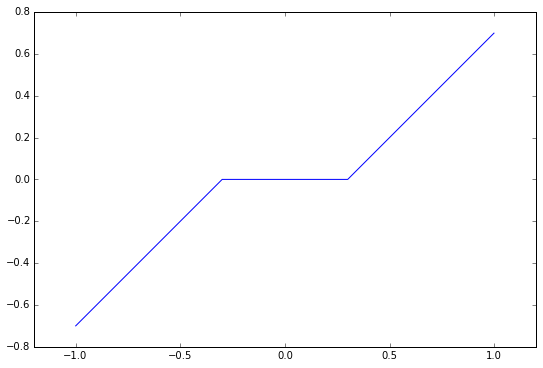

In [293]:
figsize(9,6)
t = arange(-1,1,0.001)
plot(t, prox_gamma_g(t,0.3))
axis('equal')

The proximity operator of $\gamma$ times the indicator function of $\Omega$ is the projection operator onto $\Omega$ 
 and does not depends on $\gamma$.
$$ \mathrm{prox}_{\gamma f}(x)=\mathrm{prox}_{\iota_\Omega}(x)=P_\Omega(x)  = x + A^* (A A^*)^{-1} (y-Ax). $$

In [294]:
pA = pinv(A) # pseudo-inverse. Equivalent to pA = A.T.dot(inv(A.dot(A.T)))
def prox_f(x, y):
    return x + pA.dot(y-A.dot(x))

We set the values of $\gamma$ and $\rho$.
Try different values to speed up the convergence.

In [295]:
gamma = 0.1 # try 1, 10, 0.1
rho = 1     # try 1, 1.5, 1.9

Number of iterations.

In [296]:
nbiter = 700

Implement nbiter iterations of the Douglas-Rachford algorithm.
Keep track of the evolution of the $\ell^1$ norm.

In [297]:
s = zeros(N)
En_array = zeros(nbiter)
for iter in range(nbiter):  # iter goes from 0 to nbiter-1
    x = prox_f(s, y)
    z = prox_gamma_g(2*x-s, gamma)
    s = s + rho*(z-x)
    En_array[iter] = norm(x, ord=1)  
x_restored = x


We display the original and the recovered signals.

ell_2 distance between reconstruction and true signal is equal to 3.83609328769e-15


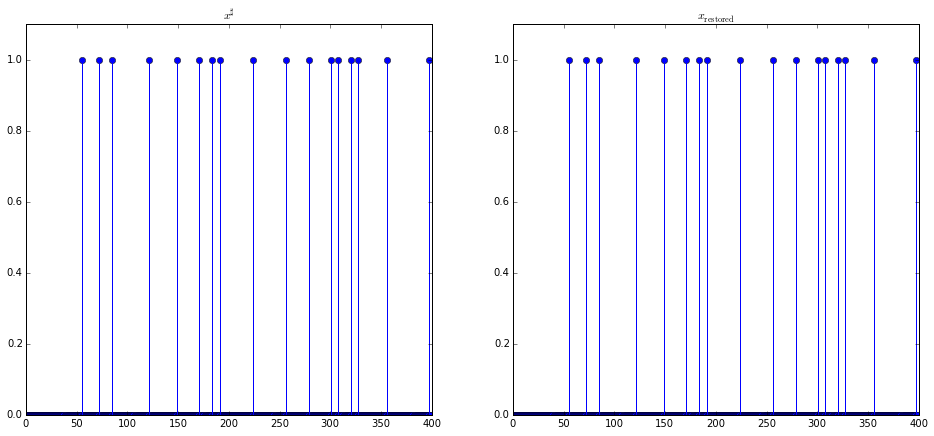

In [298]:
fig, (subfig1,subfig2) = subplots(1,2,figsize=(16,7)) # one figure with two horizontal subfigures
print("ell_2 distance between reconstruction and true signal is equal to {}".format(norm(xsharp-x_restored, ord=2)))
subfig1.stem(xsharp)
subfig1.set_ylim(0,1.1)
subfig2.stem(x_restored)
subfig2.set_ylim(0,1.1)
subfig1.set_title('$x^\sharp$')
subfig2.set_title('$x_\mathrm{restored}$')

Since the original signal is highly sparse, it is perfectly recovered.

We display the convergence speed of the $\ell^1$ norm on the first half iterations, in log
scale.

/Users/lecueguillaume/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


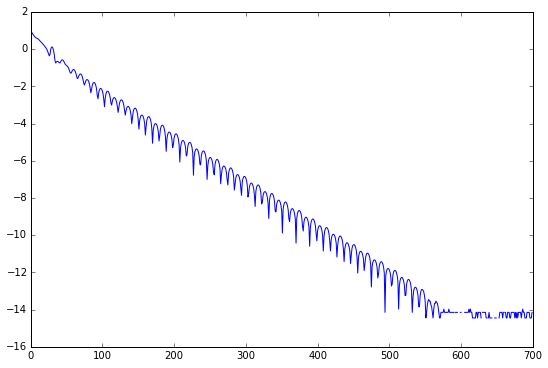

In [299]:
plot(log10(En_array-En_array.min()))

The convergence is linear in practice. Convergence up to machine precision (1e-14 here) is achieved after a few hundreds of iterations.

# Test the recovery of a less sparse signal

In [300]:
S = 31
random.seed(0)
sel = random.permutation(N)
sel = sel[0:S]   # indices of the nonzero elements of xsharp
xsharp = zeros(N)
xsharp[sel] = 1

y = A.dot(xsharp)

s = zeros(N)
En_array = zeros(nbiter)
for iter in range(nbiter):  # iter goes from 0 to nbiter-1
    x = prox_f(s, y)
    z = prox_gamma_g(2*x-s, gamma)
    s = s + rho*(z-x)
    En_array[iter] = norm(x, ord=1)  
x_restored = x

ell_2 distance between reconstruction and true signal is equal to 4.76742730137
Reconstruction failed


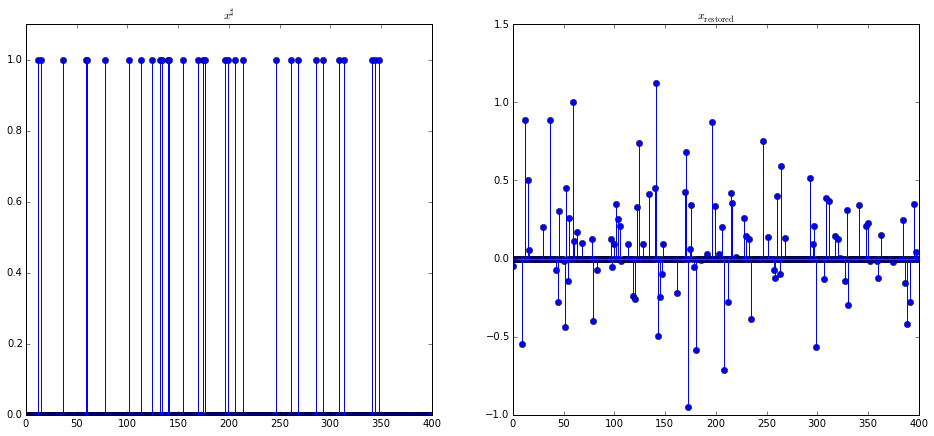

In [301]:
fig, (subfig1,subfig2) = subplots(1,2,figsize=(16,7)) # one figure with two horizontal subfigures
subfig1.stem(xsharp)
subfig1.set_ylim(0,1.1)
subfig2.stem(x_restored)
subfig1.set_title('$x^\sharp$')
subfig2.set_title('$x_\mathrm{restored}$')
dist = norm(xsharp-x_restored, ord=2)
print("ell_2 distance between reconstruction and true signal is equal to {}".format(dist))
if dist>0.001:
    print('Reconstruction failed')

/Users/lecueguillaume/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


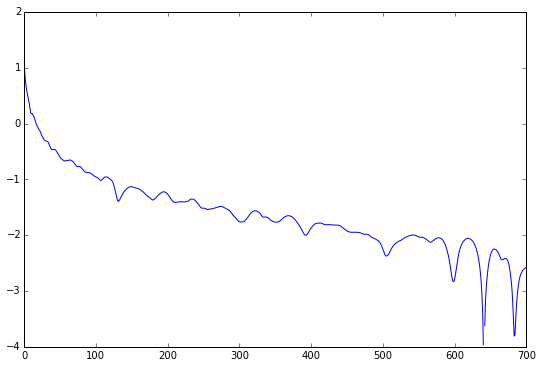

In [302]:
plot(log10(En_array-En_array.min()))

Convergence is much slower in this setting.

# Phase transition diagrams
A phase transition diagram is a usefull (simulation) tool to answer the following question:

> Given a compression matrix $A$ of size $P\times N$ and a reconstrcution algorithm (for instance the Basis Pursuit) what is the maximal sparsity parameter $S$ such that every $S$-sparse signal $x^\sharp\in\R^N$ can be exactly reconstructed from $y=Ax^\sharp$ (and $A$) using the algorithm?

To answer this question, we iterate over $s=1,2,\cdots,P$ (no need to go beyond $P$) and for each $s$ we simulate *nbtest* signals $x^\sharp$ with sparsity $s$, run the reconstruction algorithm with $y=Ax^\sharp$ and check if the reconstruction is exact (that is $||x_{restored} - x^\sharp||_2\leq 0.001$. If the reconstruction is exact for the *nbtest* signals then we plot a white pixel if reconstruction failed for all *nbtest* signals then we plot a black pixel. For every result inbetween we plot a grey (or other heatmap color) pixel. 

This gives a line of the diagram matrix for a given number of measurements $P$. Then, we repeat this construction for all $P=1,2,\ldots,N$. 

We end up with a $N\times N$ matrix and use some heatmap representation to draw the phase transition diagram. 

### Douglas-Rachford procedure

In [303]:
def signal(N, sparsity):
    sel = random.permutation(N)
    sel = sel[0:sparsity]   # indices of the nonzero elements of xsharp
    xsharp = zeros(N)
    xsharp[sel] = 1
    return xsharp

def prox_gamma_g(x, gamma):
    return x - x/maximum(abs(x)/gamma,1) # soft-thresholding

def prox_f(x, y, A, pA):
    return x + pA.dot(y-A.dot(x))

def DR(N, y, A, pA, nbiter, gamma):
    s = zeros(N)
    for iter in range(nbiter):  # iter goes from 0 to nbiter-1
        x = prox_f(s, y, A, pA)
        z = prox_gamma_g(2*x-s, gamma)
        s = s + rho*(z-x)
    return x

### Phase transition matrix

In [304]:
def phase_transition_mat(N, nbiter, gamma, nbtest):
    """return a N.N matrix with the number of reconstruction success for every  1\leq P \leq N measurements 
    and sparsity 1\leq S\leq N
    N : ambiant dimension of the signals
    nbiter : number of iteration in the DR algorithm
    gamma : threshold parameter in the soft threshold proximal function
    nbtest : number of tests for each pixel"""
    PTM = zeros((N,int(N/2)))
    set_ind_failure = []
    for P in range(1,N+1):#construct one line of the Phase transition matrix for a given number of measurements P
        if (P % 20) == 0:
            print("line number {} done".format(P))
        A = randn(P,N) / sqrt(P)
        pA = pinv(A) # pseudo-inverse. Equivalent to pA = A.T.dot(inv(A.dot(A.T)))
        ind_failure = 0
        for sparsity in range(1,min(P, int(N/2))+1):
            nb_success = 0         
            for i in range(nbtest):
                xsharp = signal(N, sparsity)
                y = A.dot(xsharp)
                x_restored = DR(N, y, A, pA, nbiter, gamma)
                if norm(x_restored-xsharp, ord=2) <0.001:
                    nb_success = nb_success + 1
            PTM[P-1, sparsity-1] = nb_success
    return PTM

### construction of the Phase transition matrix

In [305]:
N, nbiter, gamma, nbtest = 100, 20, 1, 16
mat = phase_transition_mat(N, nbiter, gamma, nbtest)# construction of the matrix with the number of success among nbtest

line number 20 done
line number 40 done
line number 60 done
line number 80 done
line number 100 done


### construction of the 'frontier'

In [306]:
def frontier(mat):
    """construction of the phase transition frontier, i.e. first time the number of success goes below nbtest/2"""
    L = []
    N = len(mat)
    for s in range(int(N/2)):
        P = 0
        while mat[P,s]<nbtest/2 and P<N-1:
            P = P + 1
        L.append(P)
    return L

### draw a heatmap of the phase transition matrix together with the frontier

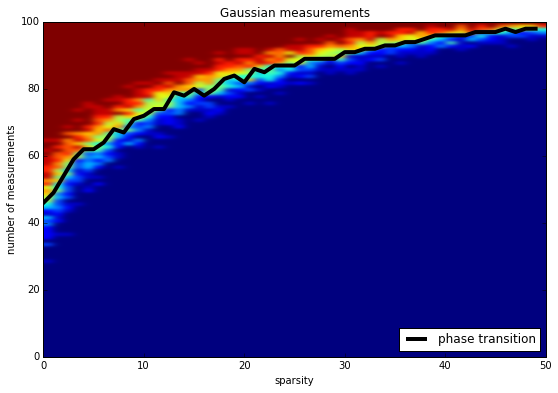

In [308]:
P_min, P_max, S_min, S_max = 0, N, 0, int(N/2)
fig = plt.imshow(mat[P_min:P_max, S_min:S_max], interpolation="gaussian",  
                 aspect='auto', origin = 'lower', extent=[S_min, S_max, P_min, P_max])
titre = "Gaussian measurements"
plt.title(titre)
plt.xlabel('sparsity')
plt.ylabel('number of measurements')

#empirical phase transition
X = range(int(N/2))
L = frontier(mat)
plot(X,L, linewidth=4, color = 'black', label='phase transition')
plt.legend(loc=4)
#Theoretical phase transition curve
#Y = [3*s*log(0.6*N/(s+1)) for s in X]
#plot(X,Y, linewidth=3, color = 'white')

plt.savefig("gaussian_100.png",bbox_inches='tight')

### repeat the construction of the frontier a hundred times to "smooth it"

In [309]:
N, nbiter, gamma, nbtest, nb_curves = 100, 20, 1, 15, 40
L = zeros(int(N/2))
for i in range(nb_curves):
    if (i % 10) == 0:
        print('step {} done'.format(i))
    mat = phase_transition_mat(N, nbiter, gamma, nbtest)
    F = frontier(mat)
    L = [sum(a) for a in zip(L,F)] 
L_gauss = [i/nb_curves for i in L]

step 0 done
line number 20 done
line number 40 done
line number 60 done
line number 80 done
line number 100 done
line number 20 done
line number 40 done
line number 60 done
line number 80 done
line number 100 done
line number 20 done
line number 40 done
line number 60 done
line number 80 done
line number 100 done
line number 20 done
line number 40 done
line number 60 done
line number 80 done
line number 100 done
line number 20 done
line number 40 done
line number 60 done
line number 80 done
line number 100 done
line number 20 done
line number 40 done
line number 60 done
line number 80 done
line number 100 done
line number 20 done
line number 40 done
line number 60 done
line number 80 done
line number 100 done
line number 20 done
line number 40 done
line number 60 done
line number 80 done
line number 100 done
line number 20 done
line number 40 done
line number 60 done
line number 80 done
line number 100 done
line number 20 done
line number 40 done
line number 60 done
line number 80 done

In [310]:
#For next use, save the Gaussian phase transition frontier in the gaussian.txt file
#filename = 'gaussian_phase_transition_{}.txt'.format(N)
#with open(filename, "w") as f:
#    for item in L:
#        f.write('{}\n'.format(item))
#f.close()

In [330]:
#import the phase transition from the file 'gaussian_phase_transition.txt'
#import csv
#filename = 'gaussian_phase_transition_{}.txt'.format(N)
#with open(filename, "r") as inputfile:
#    L_gauss = list(csv.reader(inputfile))
#L_gauss = [int(float(ele[0])) for ele in L_gauss]

### Draw the phase transition frontier for Gaussian measurements

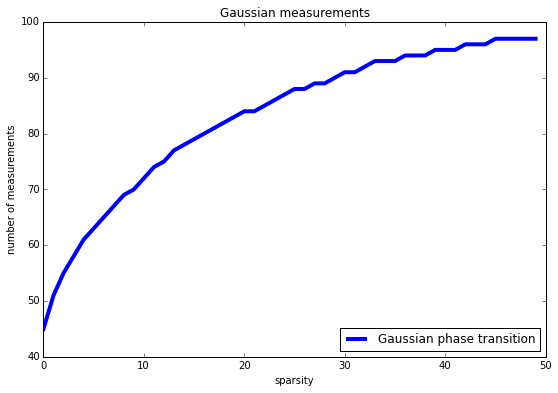

In [331]:
X = range(len(L_gauss))
plot(X,L_gauss, linewidth=4, color = 'blue', label="Gaussian phase transition")
titre = "Gaussian measurements"
plt.title(titre)
plt.xlabel('sparsity')
plt.ylabel('number of measurements')
plt.legend(loc=4)
#plt.savefig("phase_transition_curve_gaussian_100.png",bbox_inches='tight')

# Construction of (smoothed) phase transition frontiers for other type of measurements

In the two papers (available at http://lecueguillaume.github.io/research/)
> S. Dirksen, G. Lecué and H. Rauhut.
*On the gap between RIP-properties and sparse recovery conditions*

>G. Lecué and S. Mendelson.
*Sparse recovery under weak moment assumptions*

we proved that reconstruction properties (stability and robustness) of the basis pursuit algorithm goes far beyond Gaussian measurements. For instance, random matrices with i.i.d. components having only $\log N$ gaussian moments have the same "reconstruction properties" has the Gaussian one ($N$ is the size of the signals). 

The aim of this notebook is to highlight this "universality phenomenum".

### Random measurements matrices with $\psi_\alpha$ coordinates for $0<\alpha\leq2$

We construct matrices with i.i.d. coordinates with exponential moments. Note that if $g$ is a standard Gaussian variable then $ {\rm sign}(g) |g|^{2/\alpha}$ is exactly a $\psi_\alpha$ random variable (with mean zero).

In [337]:
def mat_exp_power(P, N, alpha):
    A = randn(P,N)/ sqrt(P)
    return np.multiply(np.power(A,int(2/alpha)), sign(A))

In [338]:
def phase_transition_mat_exp_power(N, nbiter, gamma, nbtest, alpha):
    PTM = zeros((N,int(N/2)))
    set_ind_failure = []
    for P in range(20,N+1):#construct one line of the Phase transition matrix for a given number of measurements P
        A = mat_exp_power(P,N, alpha) 
        pA = pinv(A) # pseudo-inverse. Equivalent to pA = A.T.dot(inv(A.dot(A.T)))
        ind_failure = 0
        for sparsity in range(1,min(P, int(N/2))+1):
            nb_success = 0         
            for i in range(nbtest):
                xsharp = signal(N, sparsity)
                y = A.dot(xsharp)
                x_restored = DR(N, y, A, pA, nbiter, gamma)
                if norm(x_restored-xsharp, ord=2) <0.001:
                    nb_success = nb_success + 1
            PTM[P-1, sparsity-1] = nb_success
    return PTM

In [339]:
N, nbiter, gamma, nbtest, alpha = 100, 20, 1, 15, 1
mat = phase_transition_mat_exp_power(N, nbiter, gamma, nbtest, alpha)

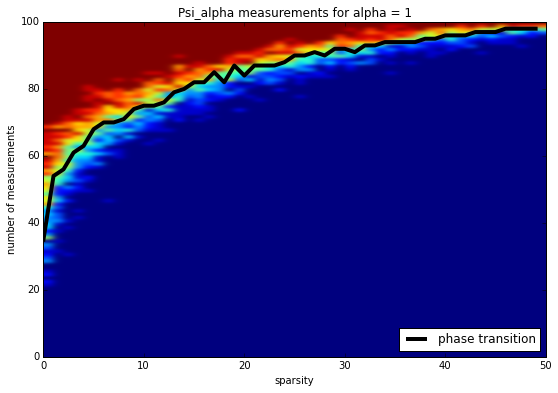

In [340]:
P_min, P_max, S_min, S_max = 0, N, 0, int(N/2)
fig = plt.imshow(mat[P_min:P_max, S_min:S_max], interpolation="gaussian",  
                 aspect='auto', origin = 'lower', extent=[S_min, S_max, P_min, P_max])
titre = "Psi_alpha measurements for alpha = {}".format(alpha)
plt.title(titre)
plt.xlabel('sparsity')
plt.ylabel('number of measurements')

#empirical phase transition
X = range(int(N/2))
L = frontier(mat)
plot(X,L, linewidth=4, color = 'black', label='phase transition')
plt.legend(loc=4)

#filename = "exp_power_{}_{}.png".format(alpha, N)
#plt.savefig(filename,bbox_inches='tight')

In [341]:
N, nbiter, gamma, nbtest, nb_curves = 100, 20, 1, 20, 30
L = zeros(int(N/2))
dict_exp_power = {1: L, 1.5: L, 0.8: L, 0.5: L}
for alpha in dict_exp_power.keys():
    print("power {} running".format(alpha))
    for i in range(nb_curves):            
        mat = phase_transition_mat_exp_power(N, nbiter, gamma, nbtest, alpha)
        F = frontier(mat)
        dict_exp_power[alpha] = [sum(a) for a in zip(dict_exp_power[alpha], F)] 
    dict_exp_power[alpha] = [ele/nb_curves for ele in dict_exp_power[alpha]]

power 1.5 running
power 1 running
power 2 running
power 0.8 running
power 0.5 running


In [342]:
#save the dictionary of phase transitions curves
#import pickle
#with open('dictionnaries_exp_power_100_v2.p', 'wb') as fp:
    pickle.dump(dict_exp_power, fp)
    
#to load the dictionary
#with open('dictionnaries_exp_power_100.p', 'rb') as fp:
#    dict_exp_power = pickle.load(fp)

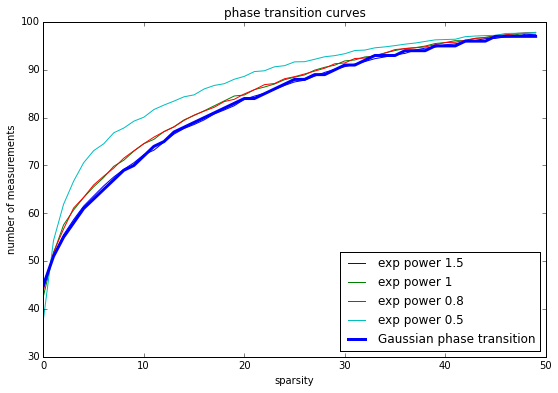

In [344]:
X = range(int(N/2))
for key in dict_exp_power.keys():
    if key != 2:
        L = dict_exp_power[key]
        text = 'exp power {}'.format(key)
        plot(X, L, label = text)
plt.legend(loc=4)
plt.xlabel('sparsity')
plt.ylabel('number of measurements')
plt.title('phase transition curves')
plot(X,L_gauss, linewidth=3, color = 'blue', label="Gaussian phase transition")
plt.legend(loc=4)
#plt.savefig("phase_transition_curves_exp_power_100_v2.png",bbox_inches='tight')

### Random measurements matrices with coordinates in $L_p$
For this example, we construct $P\times N$ i.i.d. Student variables with $k$ degrees of liberty. It has $p$ moments if and only if $k>p$.

In [324]:
def mat_power(P,N, p):
    return random.standard_t(p, size=(P,N))

In [325]:
def phase_transition_mat_power(N, nbiter, gamma, nbtest, p):
    PTM = zeros((N,int(N/2)))
    set_ind_failure = []
    for P in range(1,N+1):#construct one line of the Phase transition matrix for a given number of measurements P
        A = mat_power(P,N, p) 
        pA = pinv(A) # pseudo-inverse. Equivalent to pA = A.T.dot(inv(A.dot(A.T)))
        ind_failure = 0
        for sparsity in range(1,min(P, int(N/2))+1):
            nb_success = 0         
            for i in range(nbtest):
                xsharp = signal(N, sparsity)
                y = A.dot(xsharp)
                x_restored = DR(N, y, A, pA, nbiter, gamma)
                if norm(x_restored-xsharp, ord=2) <0.001:
                    nb_success = nb_success + 1
            PTM[P-1, sparsity-1] = nb_success
    return PTM

In [326]:
N, nbiter, gamma, nbtest, nb_curves = 100, 20, 1, 15, 20
L = zeros(int(N/2))
dict_power = {30: L, 20: L, 15: L, 10: L, 5: L, 4: L, 3: L, 2: L}
for p in dict_power.keys():
    print('power {} running'.format(p))
    for i in range(nb_curves):
        mat = phase_transition_mat_power(N, nbiter, gamma, nbtest, p)
        F = frontier(mat)
        dict_power[p] = [sum(a) for a in zip(dict_power[p], F)] 
    dict_power[p] = [ele/nb_curves for ele in dict_power[p]]

power 2 running
power 3 running
power 20 running
power 5 running
power 4 running
power 10 running
power 30 running
power 15 running


In [327]:
#save the dictionary of phase transitions curves to speed up later investigation
#import pickle
#with open('dictionnaries_power_100.p', 'wb') as fp:
#    pickle.dump(dict_power, fp)

#To load the dictionary
#with open('dictionnaries_power.p', 'rb') as fp:
#    dict_power = pickle.load(fp)

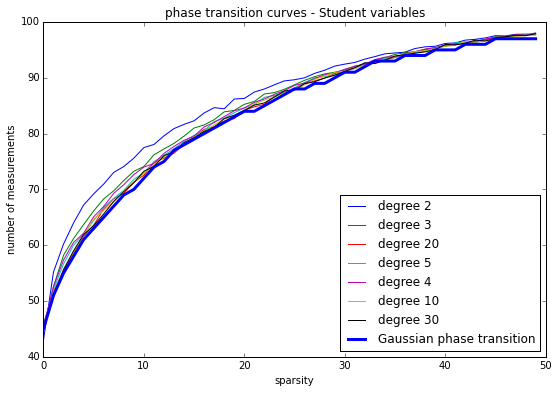

In [345]:
X = range(int(N/2))
for key in dict_power.keys():
    if key != 15:
        L = dict_power[key]
        text = 'degree {}'.format(key)
        plot(X, L, label = text)
plt.xlabel('sparsity')
plt.ylabel('number of measurements')
plt.title('phase transition curves - Student variables')
#Gaussian phase transition
plot(X,L_gauss, linewidth=3, color = 'blue', label="Gaussian phase transition")
plt.legend(loc=4)
#plt.savefig("phase_transition_curves_student_100.png",bbox_inches='tight')

### Theoretical guarentee on phase transition

Asymptotically when $N\to\infty$, existence of a phase transition, which is roughtly $$ P \geq 2e S \log\Big(\frac{N}{\sqrt{\pi}S}\Big)\approx 5.4 S \log\Big(\frac{0.6 N}{S}\Big)$$  has been proved in several papers:
>D. L. Donoho. *High-dimensional centrally symmetric polytopes with neighborliness proportional to dimension.* Discrete and Computational Geometry, 35(4):617–652, 2006.

> D. L. Donoho and J. Tanner. *Neighborliness of randomly projected simplices in high dimensions.* Proceedings of the National Academy of Sciences of the United States of America, 102(27):9452–9457, 2005.

> D. L. Donoho and J. Tanner. *Counting faces of randomly projected polytopes when the projection radically lowers dimension.* Journal of the American Mathematical Society, 22(1):1–53, 2009.

>D. L. Donoho and J. Tanner. *Observed universality of phase transitions in high-dimensional geometry, with implications for modern data analysis and signal processing*. Philosophical Transactions of the Royal Society A: Mathematical, Physical and Engineering Sciences, 367(1906):4273–4293, 2009.

> S. Oymak and J. A. Tropp. *Universality laws for randomized dimension reduction, with applications*
